출처 : https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets

신용 사기 탐지기(Credit card fraud detection)

신용 카드 회사는 사기 신용 카드 거래를 인식할 수 있으므로 고객이 구매하지 않은 항목에 대해 비용이 청구되지 않도록 하는 것이 중요하다.

이 커널에서 우리는 다양한 예측 모델을 사용하여 트랜잭션이 정상적인 결제인지 아니면 사기인지 탐지하는 데 얼마나 정확한지 확인할 것이다.
데이터 세트에 설명된 대로 기능이 확장되고 개인 정보 보호 이유로 인해 기능 이름이 표시되지 않는다.
그럼에도 불구하고, 우리는 여전히 데이터 세트의 몇 가지 중요한 측면을 분석할 수 있다.

- 목표
    - 우리에게 제공된 "작은" 데이터의 작은 분포를 이해한다.
    - "사기" 및 "비사기" 트랜잭션의 50/50 하위 데이터 프레임 비율을 생성한. (NearMiss 알고리즘)
    - 사용할 분류기를 결정하고 정확도가 더 높은 분류기를 결정한다.
    - 신경망(Neural Network)을 만들고 정확도를 최상의 분류기와 비교한다.
    - 불균형 데이터셋으로 인한 일반적인 오류를 이해합니다.

- 개요
    - 데이터 이해하기
    - 전처리
        - scaling and Distributing
        - 데이터 나누기
    - 랜덤 UnderSampling and Oversampling
        - Distributing and Correlating
        - 이상 감지(Anomaly Detection)
        - Dimensionality Reduction and Clustering(t-SNE)
        - 분류(Classifiers)
        - 로지스틱 회귀
        - SMOTE와 Oversampling
    - 테스팅
        - 로지스틱 회귀 테스트
        - 신경망 테스트

# 1. 데이터 이해하기

데이터 세트에는 2013년 9월 유럽 카드 소지자가 신용카드로 만든 거래가 포함되어 있다.
이 데이터 세트는 2일 동안 발생한 거래르 보여 주며, 284,807 건의 거래 중 492건의 사기가 있었다.
데이터 세트는 매우 불균형하며 모지티브 클래스(사기)는 모드 거래의 0.172%를 차지한다.

PCA 변환 결과 인 숫자 입력 변수만 포함한다. 안타깝게도 기밀 유지 문제로 각 컬럼이 무슨 의미를 하는지는 알 수없다.
PCA로 변환되지 않는 유일한 기능은 '시간'과 '양'이다. '시간'에는 각 트랜잭션과 데이터 세트의 첫번째 트랜잭션 사이에 경과 된 시간(초)이 포함된다.
'금액',Amount는 거래 금액이며, 이 기능은 예에따라 비용에 민감한 학습에 사용할 수 있다.

'Class' 변수는 부정행위를 하면 1이고, 그렇지 않으면 0을 사용한다.

- 데이터 요약
    - 거래 금액은 상대적으로 적고, 모든 마운트의 평균은 대략 USD 88정도 이다. NULL 값이 없으므로 대체할 방법을 찾지 않아도 된다.
    - 대부분 트랜잭션은 부정행위(99.83%)가 아닌 반면 부정 행위 트랜잭션은 데이터 프레임에서 시간(0.17%)이 발생한다.

변수에 적용된 기술
    - PCA : 모든 변수가 PCA(Dimensionality Reduction)변환을 거쳤다.(time, amount는 제외)
    - Scaling : PCA 변환 기능을 구현하려면 이전에 Scaling을 해야 한다.



In [1]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# model 관련

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

# 다른 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import  KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# 각 컬럼의 기초 통계값 확인1
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
# null 값 체크
df.isnull().sum().max()

0

In [5]:
df.columns


Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [6]:
print('No Frauds', round(df['Class'].value_counts()[0] / len(df) *100,2), '%of the dataset')
print('Frauds', round(df['Class'].value_counts()[1] / len(df) *100,2), '%of the dataset')

No Frauds 99.83 %of the dataset
Frauds 0.17 %of the dataset


위의 데이터를 보면 원본 데이터 세트가 얼마나 불균형한지 주목해야 한다.
대부분의 거래는 사기가 아니다. 이 데이터 프레임을 예측 모델 및 분석의 기반으로 사용하면 오류가 많이 발생할 수 있으며
대부분의 트랜잭션이 부정 행위가 아니라고 "가정"하기 때문에 알고리즘이 지나치게 적합할 수 있습니다.
하지만 우리는 우리 모델이 부정행위의 징후를 보이는 패턴을 탐지하기를 원하지 않는다.


Text(0.5, 1.0, 'Class Distribution \n (0: No Fraud || 1:Fraud')

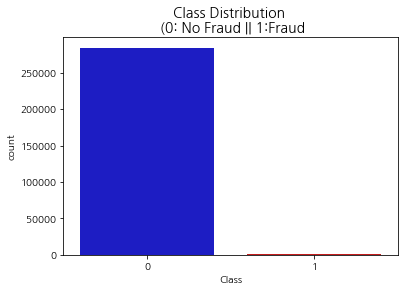

In [7]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('Class', data=df, palette=colors)
plt.title('Class Distribution \n (0: No Fraud || 1:Fraud', fontsize=14)

분포를 보면 이러한 현상이 얼마나 치우쳐 있는지 알 수 있으며, 다른 형상의 추가 분포도 볼수 있다.
향후 이 노트북에서 구현될 배포의 왜곡을 줄이는 데 도움이 될 수 있는 기술들이 있다.


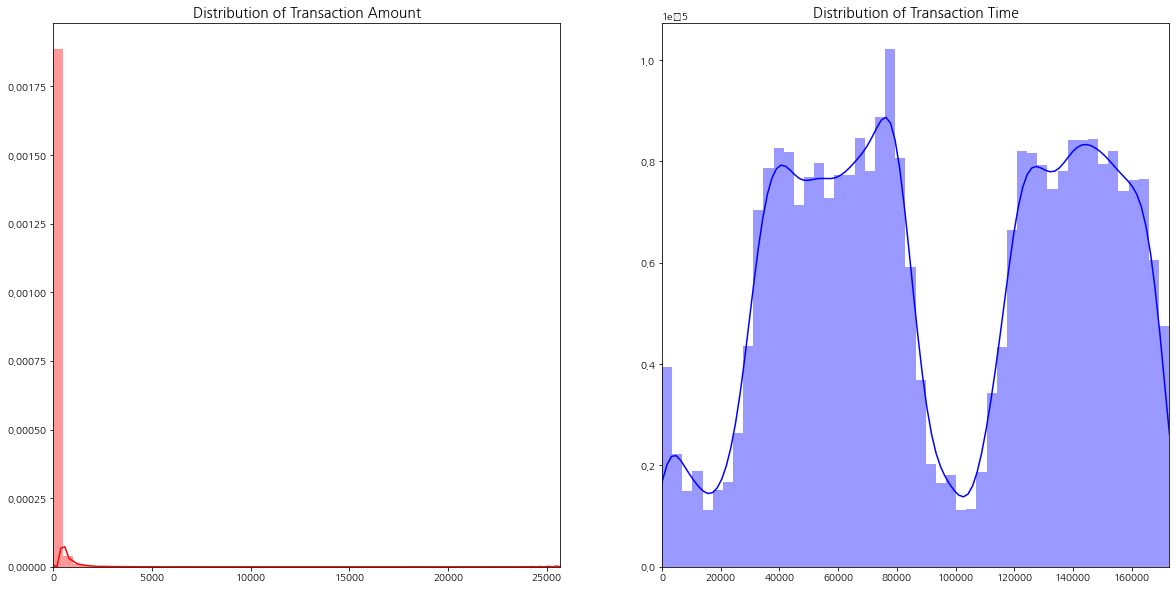

In [8]:
fig, ax = plt.subplots(1,2,figsize=(20,10))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

# 2. 전처리
## 2.1 scaling and Distributing

커널의 이 단계에서는 먼저 time과 amount으로 구성된 열을 확장할 것입니다.
time과 amount은 다른 열과 같이 조정해야 합니다.
한편, 우리는 동일한 양의 부정 행위 및 비 부정 행위 사례를 갖기 위해 데이터 프레임의 하위 샘플을 생성하여 트랜잭션이 부정 행위인지 여부를 결정하는 패턴을 더 잘 이해할 수 있도록 도와야 한다.

- sub-Sample 이란 무엇이냐?
    - 이 시나리오에서 우리의 하위 샘플은 50/50의 부정 행위 및 비사기 거래 비율을 가진 데이터 프레임이 될 것이다.
    - 즉, sub-Sample은 동일한 양의 부정 행위 및 비 부정 행위 트랜잭션을 가집니다.

- sub-Sample 을 만드는 이유는 무엇입니까?
    앞에서 원본 데이터가 심하게 불균형한 것을 확인했다. 이 데이터를 그대로 사용하면 다음과 같은 문제가 발생한다.
    - 과적합(overfitting): 우리의 분류 모델은 대부분의 경우 사기는 없다고 가정할 것이다. 우리가 우리 모델에 원하는 것은 사기가 발생했을 때 확실해지는 것이다.
    - 잘못된 상관 관계: 주어진 변수들이 이 무엇을 의미하는지 알 수는 없지만, 클래스 및 기능 간의 실제 상관 관계를 확인할 수 없는 불균형 데이터 프레임을 통해 이러한 각 기능이 결과에 어떤 영향을 미치는지 이해하는 것이 유용할 것입니다(사기 또는 부정 행위 없음).

- 요약:
    - Scaled amount과 Scaled time은 scaled value을 가진 컬럼입니다.
    - 데이터 세트에 492건의 부정 행위 사례가 있으므로 492건의 부정 행위 사례를 무작위로 가져와 새로운 sub dataframe을 생성할 수 있다.
    - 492건의 사기 및 비사기 사례를 연결하여 새로운 sub-sample을 생성한다.

In [9]:
from sklearn.preprocessing import StandardScaler, RobustScaler
# RobustScaler 가 outlier 값에 덜 노출 된다.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# 기존 컬럼은 삭제
df.drop(['Time', 'Amount'], axis=1, inplace=True)

In [10]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

# 다시 dataframe 정렬
df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


## 2.2 데이터 나누기
Random UnderSampling을 적용하기 전에 원래 데이터 프레임을 분리해야 한다.
테스트 목적으로 랜덤 언더 샘플링 또는 오버 샘플링 기술을 구현할 때,데이터를 분할한다.
하지만, 이러한 기술 중 하나에 의해 생성된 데이터세트가 아닌 원래 데이터 세트에서 모델을 테스트하고자 하는 이유를 기억해야한다.
이렇게 테스트를 하는 이유는 표본이 부족했던 데이터 프레임에 모델을 적용시키고 원래 테스트 데이터에서 테스트를 진행하기 위해서이다.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X,y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]


No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]


In [12]:
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('-'*100)

print('Label Distributions: \n')
print(train_counts_label / len(original_ytrain))
print(test_counts_label / len(original_ytest))

----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


# 3. 랜덤 UnderSampling and Oversampling
프로젝트의 이 단계에서는 우리는 보다 균형 잡힌 데이터 세트를 갖기 위해 기본적으로 데이터를 제거하여 모델이 과적합 되지 않도록 하기 위해
구성된 "Random UnderSampling"을 구현할 것이다.

- 샘플링 방법
    - 언더 샘플링(undersampling)
        - 많은 데이터 세트를 적은 데이터 수준으로 감소 시키는 것. 
        - 즉, 정상 레이블을 가진 데이터 10,000건 이상 레이블을 가진 데이터가 100건이 있으면 정상 레이블 데이터를 100건으로 줄여버리는 방식.
        - 단점 : 과도하게 정상 레이블로 학습/예측하는 부작용을 개선할 순 있지만, 너무 많은 데이터를 감소시키기 때문에 정상 레이블의 경우 오히려 제대로 된 학습을 수행할 수 없다.
    - 오버 샘플링(oversampling)
        - 이상 데이터와 같이 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보하는 방법 
        - 원본 데이터의 피처 값들을 아주 약간만 변경하여 증식함. 
        - 대표적으로 SMOTE(Synthetic Minority Over-Sampling Technique)방법이 있음.
            - SMOTE: 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃(K Nearest Neighbor)을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터를 생성하는 방식.



In [13]:
df = df.sample(frac=1)

fraud_df = df.loc[df['Class'] == 1]
non_fraud_df  = df.loc[df['Class'] == 0][:492]

normal_distributed_df= pd.concat([fraud_df, non_fraud_df])

new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
271805,-0.279746,0.940601,-1.884596,1.917237,0.397137,-1.345021,0.901485,-0.618572,1.880378,-1.815193,...,0.280778,-0.057670,-0.132690,0.053564,0.050694,-1.392314,-0.356587,-2.810152,-0.797600,0
150669,2.326836,0.107708,-10.632375,7.251936,-17.681072,8.204144,-10.166591,-4.510344,-12.981606,6.783589,...,-0.810146,2.715357,0.695603,-1.138122,0.459442,0.386337,0.522438,-1.416604,-0.488307,1
50409,0.964158,-0.472444,-1.034058,0.794847,-0.366211,0.284920,2.533730,4.361385,-0.868533,-1.986624,...,0.648424,-1.421613,0.253240,-0.368613,1.031479,-0.101026,-0.310346,-0.017136,-0.102407,0
81186,0.330329,-0.303927,-4.384221,3.264665,-3.077158,3.403594,-1.938075,-1.221081,-3.310317,-1.111975,...,-0.141533,2.076383,-0.990303,-0.330358,0.158378,0.006351,-0.493860,-1.537652,-0.994022,1
192382,-0.279466,0.528390,0.753356,2.284988,-5.164492,3.831112,-0.073622,-1.316596,-1.855495,0.831079,...,0.285792,0.382007,0.033958,0.187697,0.358433,-0.488934,-0.258802,0.296145,-0.047174,1


## 3.1 Distributing and Correlating

이제 데이터 프레임의 균형이 올바르게 잡혔으므로 분석 및 데이터 사전 처리를 더 진행할 수 있다.

Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


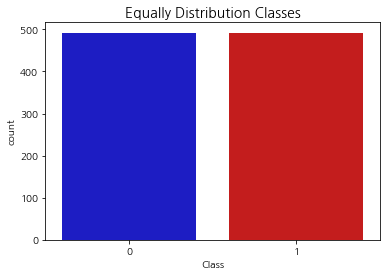

In [14]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))

sns.countplot('Class', data=new_df, palette=colors)
plt.title('Equally Distribution Classes', fontsize=14)
plt.show()

# 4. 상관 행렬

상관행렬을 통해 특정 트랜잭션이 사기인지 여부에 큰 영향을 미치는지 확인한다.
그러나 부정 거래와 관련하여 양 또는 음의 상관 관계가 높은 기능을 확인하려면 올바른 subsample을 사용하는 것이 중요하다.
subsample을 이용하지 않으면 상관 행렬이 클래스 간의 높은 불균형에 의해 영향을 받게 된다. 이 문제는 원래 데이터 프레임의
높은 클래스 불균형 때문에 발생한다.

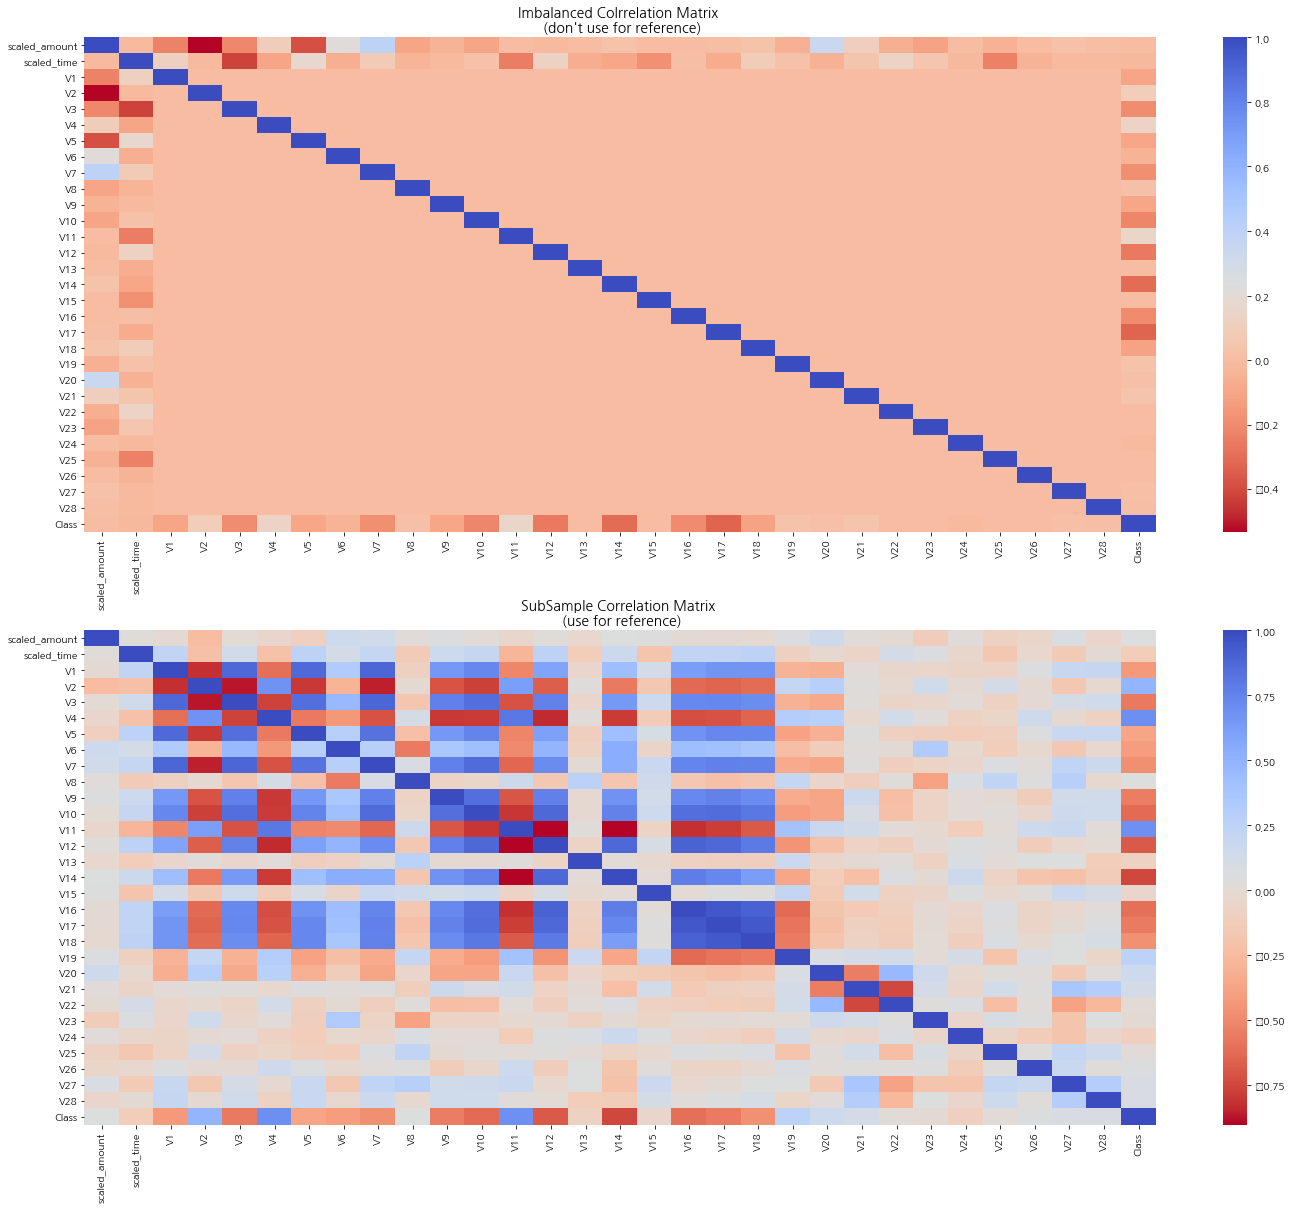

In [15]:
F, (ax1, ax2) = plt.subplots(2,1, figsize=(24,20))

corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Colrrelation Matrix \n (don't use for reference)", fontsize=14)

sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20},ax=ax2 )
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

'Class'의 상관행렬 분석 결과
    - 음의 상관 : V17, V14, V12, V10, 이러한 값이 낮을 수록 최종 결과는 부정 거래일 가능성이 높음.
    - 양의 상관 : V2, V4, V11, V19 값이 높을 수록 부정 거래 가능성이 높음.


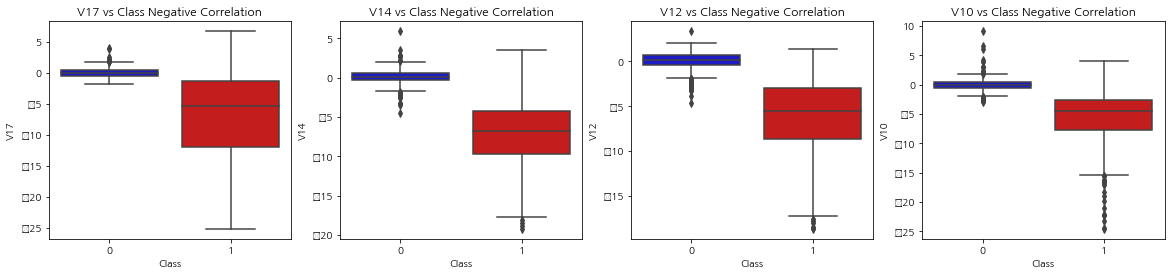

In [16]:
f, axes = plt.subplots(ncols=4, figsize = (20,4))
sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

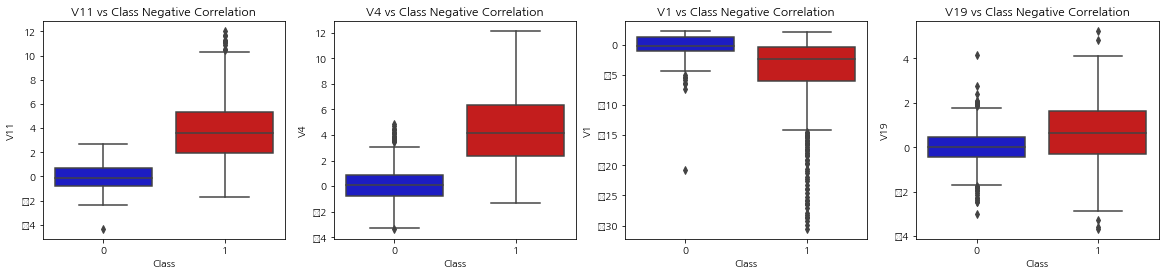

In [17]:
f, axes = plt.subplots(ncols=4, figsize = (20,4))
sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V1", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V1 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Negative Correlation')

plt.show()


## 4.1 이상 감지(Anomaly Detection)
이상감지에서 주요 목표는 클래스와의 상관관계가 높은 변수에서 'outlier'를 제거하느 ㄴ것이다.
이것은 모델 정확성에 긍정적인 영향을 미친다.

- 사분위간 범위 방법
    - 사분위간 범위(IQR): 75번째 백분위수와 25번째 백분위수의 차이로 계산한다. 목표는 75번째 및 25번째 백분위수 이상의 임계값을 만드는 것이며, 어떤 인스턴스가 이 임계값을 통과할 경우 인스턴스가 삭제될 것이다.
    - 상자 그림: 25번째 백분위수와 75번째 백분위수(양쪽 끝)를 쉽게 볼 수 있을 뿐만 아니라 특이치(하한과 높은 극단값을 초과하는 점)도 쉽게 볼 수 있습니다.

- 특이치 제거 트레이드오프
    특이치를 제거하기 위한 임계값은 어디까지로 지정할지 주의해야 한다. 숫자(예: 1.5)에 사분위간 범위(사분위간 범위)를 곱하여 임계값을 결정한다.
    이 임계값이 높을수록 특이치가 더 적게 탐지되고(더 높은 수의 ex: 3) 이 임계값은 더 많은 특이치를 탐지합니다.
    - 트레이드오프: 그러나 문턱값이 낮을수록 특이치가 더 많이 제거되기 때문에 특이치보다는 "극한 특이치"에 더 초점을 맞추려고 한다.
    그 이유는 모형의 정확도가 낮아지는 정보 손실 위험을 실행할 수 있기 때문이다. 이 임계값을 사용하여 분류 모델의 정확도에 어떤 영향을 미치는지 확인할 수 있다.





Text(0.5, 1.0, 'V10 Distribution \n (Fraud Transactions)')

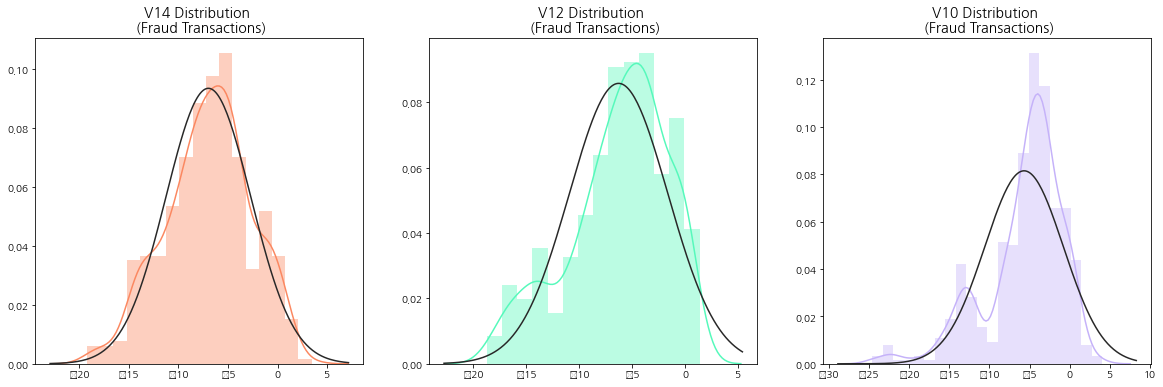

In [18]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (20,6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] ==1 ].values
sns.distplot(v14_fraud_dist, ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] ==1 ].values
sns.distplot(v12_fraud_dist, ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)

v10_fraud_dist = new_df['V10'].loc[new_df['Class'] ==1 ].values
sns.distplot(v10_fraud_dist, ax=ax3, fit=norm, color='#C5B2F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)


- 요약
    - 분포 시각화: 먼저 일부 특이치를 제거하기 위해 사용할 형상의 분포를 시각화하는 것으로 시작한다. 변수 V12 및 V10에 비해 가우스 분포가 있는 기능은 V14뿐이다.
    - 임계값 결정: IQR(더 낮은 특이치를 제거할수록)과 곱하기 위해 사용할 숫자를 결정한 후에는 q25 - 임계값(더 낮은 극단 임계값)을 하위로 지정하고 q75 + 임계값(상위 극단 임계값)을 추가하여 상한 및 하한 임계값을 계속 결정한다.
    - 조건부 드롭: 마지막으로, 양쪽 극단에서 "임계값"을 초과하면 인스턴스가 제거된다는 것을 나타내는 조건부 드롭을 만든다.
    - 상자 그림 표현: 상자 그림을 통해 "극한 특이치"의 수가 상당한 양으로 감소했음을 시각화한다.


In [19]:
# V14 특이치 제거하기 (가장 높은 Negative 상관 행렬을 가진 변수)

v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25 : {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper  = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))

outliers = [x for x in v14_fraud if x < v14_lower or x> v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))

print('V14 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('----'*44)

Quartile 25 : -9.692722964972385 | Quartile 75: -4.282820849486866
iqr: 5.409902115485519
Cut off: 8.114853173228278
V14 Lower: -17.807576138200663
Feature V14 Outliers for Fraud Cases: 4
V14 outliers:[-18.8220867423816, -19.2143254902614, -18.049997689859396, -18.4937733551053]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [20]:
# V12 특이치 제거하기 

V12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(V12_fraud, 25), np.percentile(V12_fraud, 75)
print('Quartile 25 : {} | Quartile 75: {}'.format(q25, q75))
V12_iqr = q75 - q25
print('iqr: {}'.format(V12_iqr))

V12_cut_off = V12_iqr * 1.5
V12_lower, V12_upper  = q25 - V12_cut_off, q75 + V12_cut_off
print('Cut off: {}'.format(V12_cut_off))
print('V12 Lower: {}'.format(V12_lower))

outliers = [x for x in V12_fraud if x < V12_lower or x> V12_upper]
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))

print('V12 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V12'] > V12_upper) | (new_df['V12'] < V12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----'*44)

Quartile 25 : -8.67303320439115 | Quartile 75: -2.893030568676315
iqr: 5.780002635714835
Cut off: 8.670003953572252
V12 Lower: -17.3430371579634
Feature V12 Outliers for Fraud Cases: 4
V12 outliers:[-18.683714633344298, -18.047596570821604, -18.553697009645802, -18.4311310279993]
Number of Instances after outliers removal: 975
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [21]:

# V10 특이치 제거하기 

V10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(V10_fraud, 25), np.percentile(V10_fraud, 75)
print('Quartile 25 : {} | Quartile 75: {}'.format(q25, q75))
V10_iqr = q75 - q25
print('iqr: {}'.format(V10_iqr))

V10_cut_off = V10_iqr * 1.5
V10_lower, V10_upper  = q25 - V10_cut_off, q75 + V10_cut_off
print('Cut off: {}'.format(V10_cut_off))
print('V10 Lower: {}'.format(V10_lower))

outliers = [x for x in V10_fraud if x < V10_lower or x> V10_upper]
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))

print('V10 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V10'] > V10_upper) | (new_df['V10'] < V10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----'*44)

Quartile 25 : -7.466658535821848 | Quartile 75: -2.5118611381562523
iqr: 4.954797397665596
Cut off: 7.4321960964983935
V10 Lower: -14.89885463232024
Feature V10 Outliers for Fraud Cases: 27
V10 outliers:[-14.9246547735487, -16.7460441053944, -24.403184969972802, -15.1237521803455, -15.346098846877501, -22.1870885620007, -15.2399619587112, -16.6496281595399, -15.563791338730098, -14.9246547735487, -24.5882624372475, -16.3035376590131, -19.836148851696, -22.1870885620007, -22.1870885620007, -16.6011969664137, -17.141513641289198, -15.2399619587112, -18.9132433348732, -18.2711681738888, -15.124162814494698, -23.2282548357516, -20.949191554361104, -22.1870885620007, -16.2556117491401, -15.2318333653018, -15.563791338730098]
Number of Instances after outliers removal: 945
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



참고: 특이치 감소를 구현한 후 정확도가 3% 이상 향상되었다.
일부 특이치는 모형의 정확도를 왜곡할 수 있지만, 우리는 과도한 양의 정보 손실을 방지해야 하며 그렇지 않으면 모형이 과소 적합될 위험이 있다는 점을 기억해야 한다.

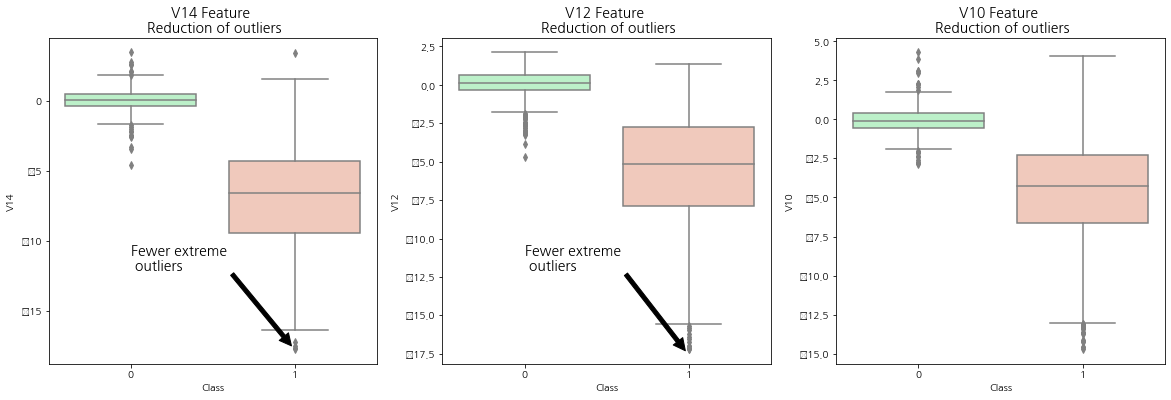

In [22]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,6))
colors = ['#B3F9C5', '#f9c5b3']

#Boxplots with outliers removed
# V14 변수
sns.boxplot(x="Class", y="V14", data=new_df, ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers ', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'), fontsize=14)

# V12 변수
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers ', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'), fontsize=14)

# V10 변수
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers ', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'), fontsize=14)

plt.show()

## 4.2 Dimensionality Reduction and Clustering(t-SNE)
- t-SNE는 각 데이터 포인트를 2차원에 무작위로 표현한 후 원본 특성 공간에서 가가운 포인트는 가깝게, 멀리 떨어진 포인트는 멀어지게 만든다. 
    즉, 이웃 데이터 포인트에 대한 정보를 보존하려고 노렴함.
- t-SNE 알고리즘을 이해하려면 다음 용어를 이해해야 한다.    
    - 유클리드 거리
    - 조건부 확률
    - 정규 분포도 및 T 분포도


- summary
    - t-SNE 알고리즘은 데이터 세트에서 부정 행위 및 비사기 사례들을 상당히 정확하게 클러스터링할 수 있다.
    - 하위 샘플은 매우 작지만, t-SNE 알고리듬은 모든 시나리오에서 클러스터를 꽤 정확하게 감지할 수 있다(t-SNE를 실행하기 전에 데이터 세트를 섞는다).
    - 이는 추가적인 예측 모델이 사기 사례와 비사기 사례를 분리하는 데 상당히 좋은 성과를 거둘 것임을 시사한다.

In [23]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1-t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1-t0))

# PCA Implementation
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1-t0))

T-SNE took 5.9 s
PCA took 0.026 s
Truncated SVD took 0.005 s


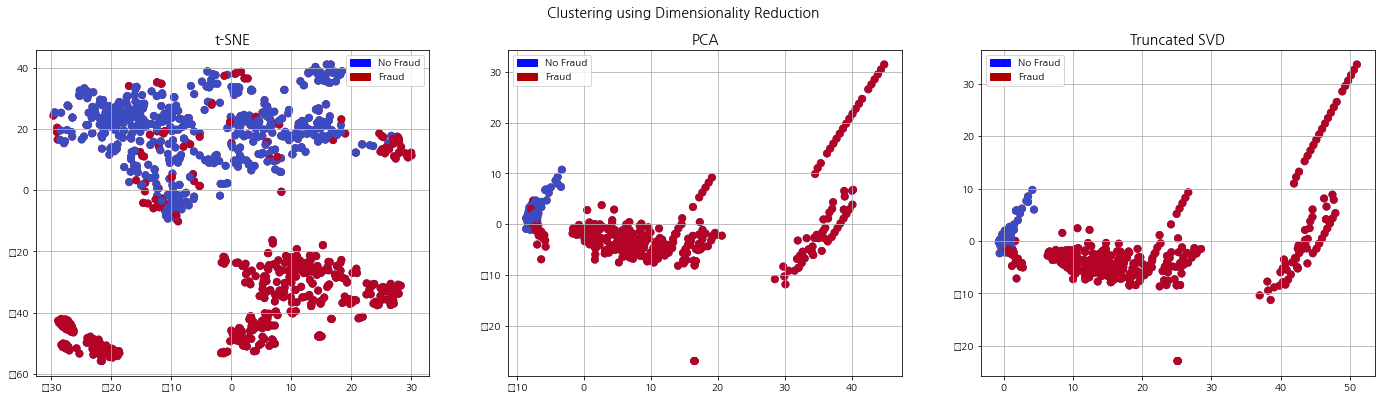

In [24]:
f, (ax1, ax2, ax3 ) = plt.subplots(1,3, figsize=(24,6))
f.suptitle('Clustering using Dimensionality Reduction', fontsize = 14)

blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')
color_num = 2

# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y==0), cmap= plt.cm.coolwarm, label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y==1), cmap= plt.cm.coolwarm, label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)
ax1.legend(handles =[blue_patch, red_patch])

# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y==0), cmap= plt.cm.coolwarm, label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y==1), cmap=plt.cm.coolwarm, label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)
ax2.legend(handles =[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y==0), cmap= plt.cm.coolwarm, label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y==1), cmap=plt.cm.coolwarm, label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)
ax3.legend(handles =[blue_patch, red_patch])

plt.show()

## 4.3 분류(Classifiers)
분류기(언더샘플링):
이 섹션에서는 네 가지 유형의 Classifiers를 교육하고, 어떤 Classifier가 부정 거래를 탐지하는 데 더 효과적인지 결정한다. 
그전에 우리는 데이터를 교육 데이터 세트와 테스트 데이터 세트로 나누고 레이블로 부터 변수를 분리해야 한다.

- Summary
    - 로지스틱 회귀 분류기 : 대부분의 경우 다른 세 Classifier 보다 정확하다. (로지스틱 회귀 분석 추가)
    - GridSearchCV : Classifier 대해 최상의 예측 점수를 제공하는 매개 변수를 결정하는 데 사용된다.
    - 로지스틱 회귀 분석에서는 가장 좋은 ROC(수신 작동 특성 점수)가 있다. 이 ROC 기법은 로지스틱 회귀 분석에서는 부정 행위와 부정 행위 이외의 트랜잭션을 상당히 정확하게 구분한다.

- 참고
    - training score와 cross validation score의 간격이 넓을수록 모형이 과대 적합될 가능성이 높습니다 (고분산).
    - training score와 cross validation score 모두 점수가 낮은 경우 과소 적합할 가능성이 높다.(높은 편향).
    - 로지스틱 회귀 분석 Classifier 는 교육 세트와 교차 검증 세트 모두에서 가장 높은 점수를 표시합니다.

In [25]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('Class', axis = 1)
y = new_df['Class']

In [26]:
# 데이터는 이미 training, test set으로 나눠져 있다. 
from sklearn.model_selection import train_test_split

# 딱봐도 undersampling이다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

# 이 데이터로 알고리즘을 돌려보자.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [27]:
# 이제 간단하게 classifiers를 실행시켜보자.
classifier = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

In [28]:
# 아마 cross validation 을 적용하면 높은 점수가 나올 것이다. 
from sklearn.model_selection import cross_val_score

for key, classifier in classifier.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training socre of ", round(training_score.mean(), 2)*100, "% accuracy score")

Classifiers:  LogisticRegression Has a training socre of  95.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training socre of  93.0 % accuracy score
Classifiers:  SVC Has a training socre of  93.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training socre of  90.0 % accuracy score


In [29]:
# GridSearchCV를 사용하여 best parameter를 찾아보자.

from sklearn.model_selection import GridSearchCV

log_reg_params = {
    "penalty":['l1', 'l2'],
    "C" : [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)

log_reg = grid_log_reg.best_estimator_

In [30]:
knears_params = {
    "n_neighbors" : list(range(2,5,1)),
    'algorithm' : ['auto', 'ball_tree', 'kd_tree','brute']
}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)

knears_neighbors = grid_knears.best_estimator_

In [31]:
svc_params = {
    'C': [0.5, 0.7, 0.9, 1],
    'kernel': ['rbf', 'poly', 'sigmoid', 'linear']
}

grid_svc= GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

svc = grid_svc.best_estimator_

In [32]:
tree_params = {
    "criterion":["gini", "entropy"],
    "max_depth":list(range(2,4,1)),
    "min_samples_leaf":list(range(5,7,1))
}

grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

tree_clf = grid_tree.best_estimator_

In [33]:
#Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() *100, 2).astype(str) + '%')

knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score: ', round(knears_score.mean() *100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score: ', round(svc_score.mean() *100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score: ', round(tree_score.mean() *100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  94.84%
Knears Neighbors Cross Validation Score:  93.25%
Support Vector Classifier Cross Validation Score:  94.58%
DecisionTree Classifier Cross Validation Score:  92.73%


In [34]:
# 우리는 cross validation을 하는 동안 undersampling을 할 것이다. 
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

In [35]:
for train_index, test_index in sss.split (undersample_X, undersample_y):
    print("Train:", train_index, "Test: ", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values

Train: [ 56961  56962  56963 ... 284804 284805 284806] Test:  [    0     1     2 ... 56959 56960 57237]
Train: [     0      1      2 ... 284804 284805 284806] Test:  [ 56961  56962  56963 ... 114130 114304 114409]
Train: [     0      1      2 ... 284804 284805 284806] Test:  [113920 113921 113922 ... 170890 170891 170892]
Train: [     0      1      2 ... 284804 284805 284806] Test:  [168199 168523 168652 ... 227851 227852 227853]
Train: [     0      1      2 ... 227851 227852 227853] Test:  [224710 225343 225627 ... 284804 284805 284806]


In [36]:
undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# NearMiss 기술 실행
# NearMiss 부산
X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))

NearMiss Label Distribution: Counter({0: 492, 1: 492})


In [37]:
# 올바른 방법으로 cross Validation 하기
for train, test in sss.split (undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg)
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))
    

In [38]:
# 이제 LogisticRegression Learning Curve을 plot으로 그려보자.

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim = None, cv = None,
                       n_jobs =1, train_sizes = np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
        
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha = 0.1,
                    color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha = 0.1,
                    color="#2492ff")
    
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124", label = "Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#ff9124", label = "Cross-Validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize = 14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha = 0.1,
                    color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha = 0.1,
                    color="#2492ff")
    
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124", label = "Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#ff9124", label = "Cross-Validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize = 14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    #Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha = 0.1,
                    color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha = 0.1,
                    color="#2492ff")
    
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124", label = "Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#ff9124", label = "Cross-Validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize = 14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    #Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha = 0.1,
                    color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha = 0.1,
                    color="#2492ff")
    
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124", label = "Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#ff9124", label = "Cross-Validation score")
    ax4.set_title("Support Vector Classifier \n Learning Curve", fontsize = 14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    
    return plt
    
    

<module 'matplotlib.pyplot' from 'c:\\users\\hanbit\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

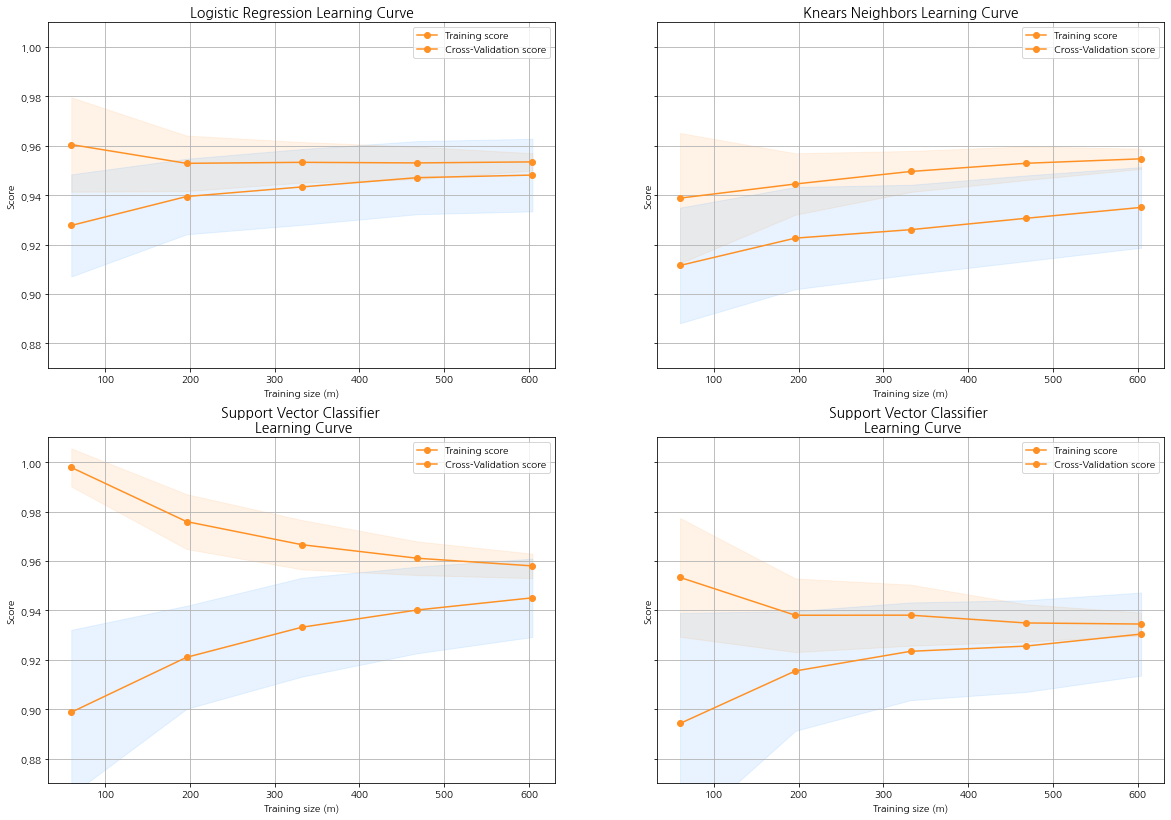

In [39]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

training size가 커지면 커질수록 trainig score, cross-valication score는 비슷해져간다.

이제 ROC 곡선으로 보자.

In [40]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv =5, method="decision_function")
knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv =5)
svc_pred = cross_val_predict(svc, X_train, y_train, cv =5, method="decision_function")
tree_pred = cross_val_predict(tree_clf,  X_train, y_train, cv =5)

In [41]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9791635952626665
KNears Neighbors:  0.9291611381394663
Support Vector Classifier:  0.9770364286065303
Decision Tree Classifier:  0.9245908889871738


In [42]:
# plot으로 표현해보자.

log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_thresold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_thresold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_thresold = roc_curve(y_train, tree_pred)

In [43]:
def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svf_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label= 'Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label= 'KNear Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))    
    plt.plot(svc_fpr, svc_tpr, label= 'Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label= 'Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    
    plt.plot([0, 1], [0,1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6,0.3),
                arrowprops = dict(facecolor = '#6E726D', shrink=0.05),)
    plt.legend()    


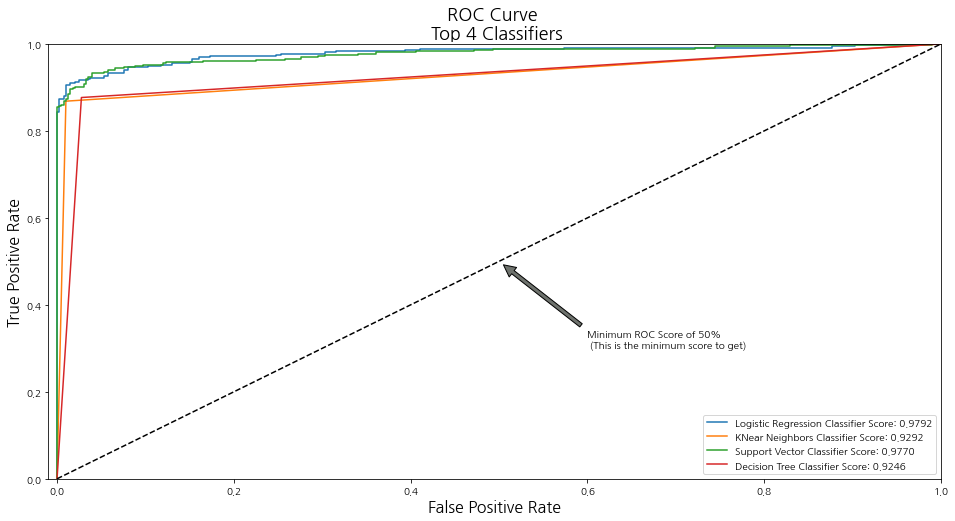

In [44]:
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

## 4.4 로지스틱 회귀

- 용어 
    - True Positives : Correctly Classified Fraud Transactions
    - False Positives : Incorrectly Classified Fraud Transactions
    - True Negative : Correctly Classified Non-Fraud Transactions
    - False Negative : Incorrectly Classified Non-Fraud Transactions
    - Precision(정밀도)
        - True Positives / (True Positives + False Positives)
    - Recall(재현도)
        - True Positives / (True Positives + False Negative)        
        

In [45]:
 def logistic_roc_curve(log_fpr, log_tpr):
        plt.figure(figsize=(12,8))
        plt.title('Logistic Regression ROC Curve', fontsize = 16)
        plt.plot(log_fpr, log_tpr, 'b-', linewidth = 2)
        plt.plot([0,1], [0,1], 'r--')
        plt.xlabel('False Positive Rate', fontsize=16)
        plt.ylabel('True Positive Rate', fontsize=16)
        plt.axis([-0.01, 1, 0, 1])
        

- 요약 
    - 정밀도(Precision)은 0.90~0.91 사이에서 감소하기 시작한다. 우리의 정밀도 점수는 여전히 높고, 재현율 점수도 감소하고 있다.

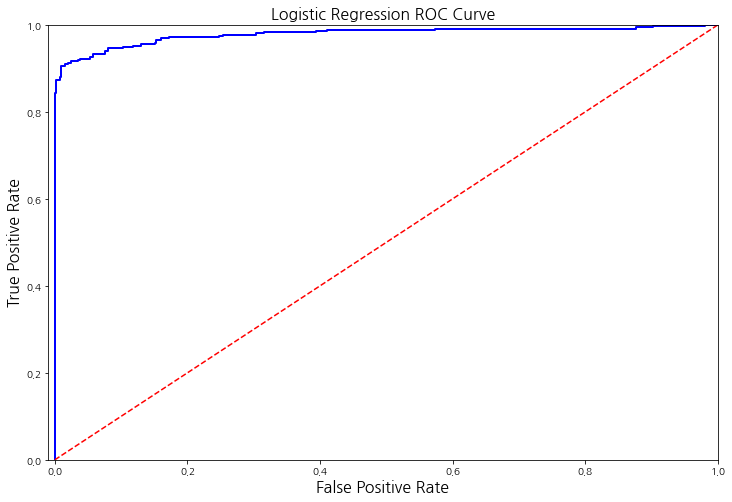

In [46]:
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [47]:
from sklearn.metrics import precision_recall_curve

precision,recall, threshold = precision_recall_curve(y_train, log_reg_pred)

In [48]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

y_pred = log_reg.predict(X_train)

In [49]:
# Overfitting Case
print('---'*45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---'*45)

# How it should look like
print('---'*45)
print('How it shold be:\n')
print('Accuracy Score: {:.2f}'.format(np.mean(undersample_accuracy)))
print('Precision Score: {:.2f}'.format(np.mean(undersample_precision)))
print('Recall Score: {:.2f}'.format(np.mean(undersample_recall)))
print('F1 Score: {:.2f}'.format(np.mean(undersample_f1)))
print('---'*45)

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.92
Precision Score: 0.82
F1 Score: 0.86
Accuracy Score: 0.86
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it shold be:

Accuracy Score: 0.76
Precision Score: 0.00
Recall Score: 0.21
F1 Score: 0.00
---------------------------------------------------------------------------------------------------------------------------------------


In [50]:
undersample_y_score = log_reg.decision_function(original_Xtest)

In [51]:
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(undersample_average_precision))

Average precision-recall score: 0.06


Text(0.5, 1.0, 'UnderSampling precision-Recall curve: \n Average Precision-Recall Score = 0.06')

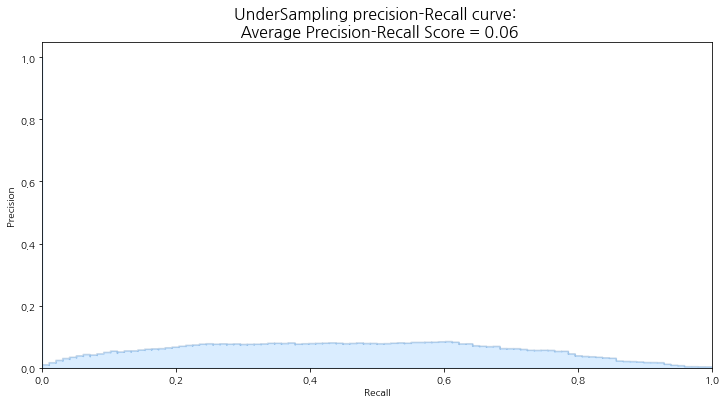

In [52]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color = '#004a93', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling precision-Recall curve: \n Average Precision-Recall Score = {0:0.2f}'.format(
            undersample_average_precision), fontsize=16)


## 4.5 SMOTE와 Oversampling

In [53]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV

print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

Length of X (train): 227846 | Length of y (train): 227846
Length of X (test): 56961 | Length of y (test): 56961


In [54]:
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

In [55]:
log_reg_sm = LogisticRegression()
rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)

In [56]:
log_reg_params = {"penalty":['l1', 'l2'], 'C': [0.001, 0.01, 0,1, 1, 10, 100, 1000]}

for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg)
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---'*45)    
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---'*45)    

---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.941965851215518
precision: 0.06096599528804144
recall: 0.9137293086660175
f1: 0.11248255949118291
---------------------------------------------------------------------------------------------------------------------------------------


In [57]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.99      0.99     56863
       Fraud       0.11      0.86      0.20        98

    accuracy                           0.99     56961
   macro avg       0.56      0.92      0.60     56961
weighted avg       1.00      0.99      0.99     56961



In [58]:
y_score = best_est.decision_function(original_Xtest)

average_precision = average_precision_score(original_ytest, y_score)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 0.75


Text(0.5, 1.0, 'OverSampling Precision-Recall curve:\n Average Precision-Recall Score=0.75')

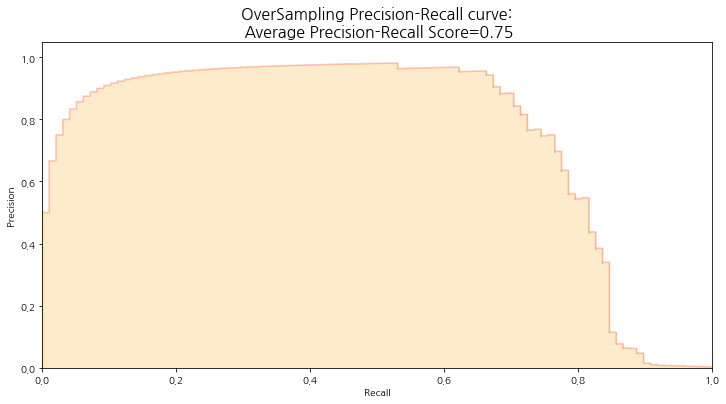

In [59]:
fig = plt.figure(figsize=(12,6))
precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('OverSampling Precision-Recall curve:\n Average Precision-Recall Score={0:0.2f}'.format(average_precision), fontsize=16)


In [60]:
# ratio parameter changes sampling_strategy
sm = SMOTE(sampling_strategy=0.6, random_state=42)

Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)

In [61]:
t0= time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversampling data took: {} sec".format(t1-t0))

Fitting oversampling data took: 5.224553108215332 sec


# 5. 테스팅
## 5.1 로지스틱 회귀 테스트

- 랜덤 undersampling:  우리는 랜덤 undersampling subset에서 분류모델의 마지막 성능평가할 것이다. 하지만 이것은 original dataframe으로 부터의 데이터가 아님을 명심하라.
- 분류 모델 : 가장 성능이 좋은 모델은 logistic regression과 SVC(Support Vector Classifier) 였다. 

In [62]:
from sklearn.metrics import confusion_matrix

# SMOTE 기법을 사용하여 Logistic Regression에 fit 하기
y_pred_log_reg = log_reg_sm.predict(X_test)

In [63]:
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)

[Text(0, 0.5, ''), Text(0, 1.5, '')]

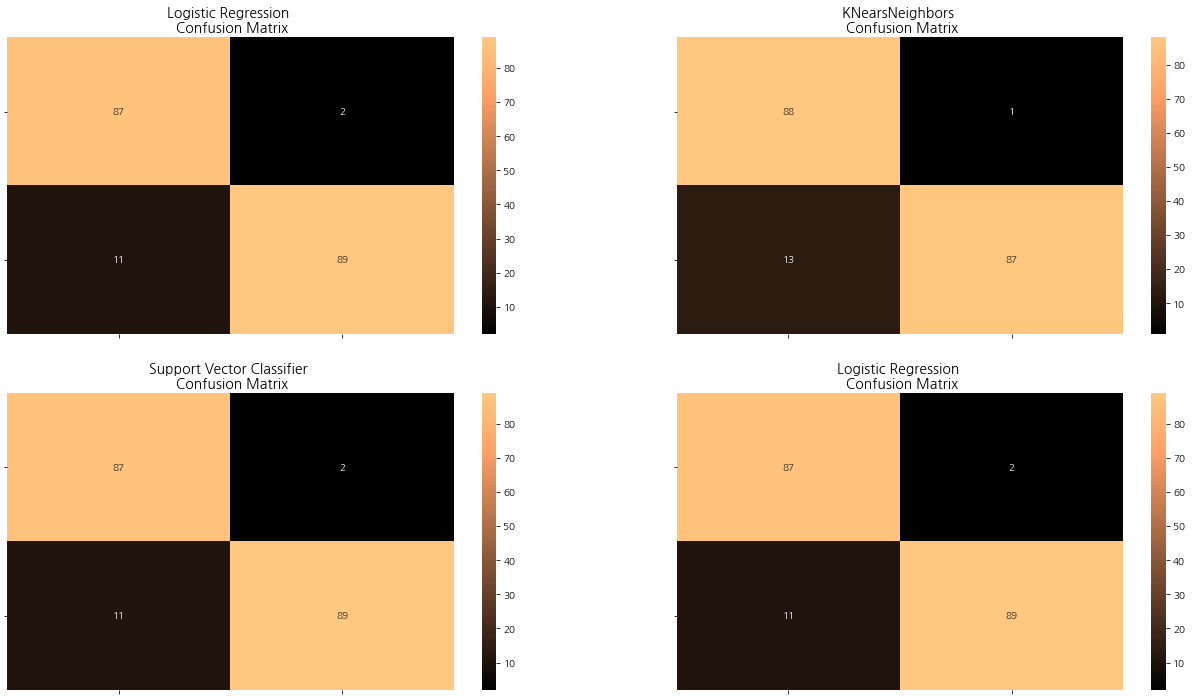

In [65]:
log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2,2,figsize=(22,12))

sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0][0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0][0].set_xticklabels(['',''], fontsize=14, rotation=90)
ax[0][0].set_yticklabels(['',''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['',''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['',''], fontsize=14, rotation=360)

sns.heatmap(log_reg_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Support Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['',''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['',''], fontsize=14, rotation=360)

sns.heatmap(log_reg_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['',''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['',''], fontsize=14, rotation=360)

In [66]:
from sklearn.metrics import classification_report

print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Tree Classifier:')
print(classification_report(y_test, y_pred_tree))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93        89
           1       0.98      0.89      0.93       100

    accuracy                           0.93       189
   macro avg       0.93      0.93      0.93       189
weighted avg       0.94      0.93      0.93       189

KNears Neighbors:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93        89
           1       0.99      0.87      0.93       100

    accuracy                           0.93       189
   macro avg       0.93      0.93      0.93       189
weighted avg       0.93      0.93      0.93       189

Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92        89
           1       0.95      0.90      0.92       100

    accuracy                           0.92       189
   macro avg       0.92      0.92      0.92       189
weighted

In [67]:
# logsitic regression의 테스트 셋의 final score 
from sklearn.metrics import accuracy_score

y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)

In [71]:
# SMOTE 기술과 Logistic Regression

y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)

d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score':[undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)


# Move Column
score = final_df['Score']
final_df.drop('Score', axis = 1, inplace=True)
final_df.insert(1, 'Score', score)

final_df


,Technique,Score
0,Random UnderSampling,0.931217
1,Oversampling (SMOTE),0.988273


점수를 비교한 결과, SMOTE 기법을 적용한 Oversampling 기법이 score가 더 높게 나왔다. 

## 5.2 신경망 테스트
- 이 섹션에서는 UnderSample 또는 OverSample(SMOTE)를 구현한 두가지 Logistic Regression 모델 중 Fraud, Non-Fraud를 탐지하는데 더 나은 모델을 확인하기 위해 간단한 신경망 모델을 구현한다. 

- 우리는 Fraud 데이터에 집중하지 않고 Non-Fraud 거래에 중점을 둘 것이다. 왜냐하면 카드 소지자가 물건을 구입한 후 은행의 알고리즘에 의해 카드가 막혔다고 하면 안되기 때문이다.
- 신경망 구조(Neural Network Structure)
    - 32개의 노드를 가진 hidden layer 구성
    - outnode는 2개(0 혹은 1)
    - learning late : 0.001
    - optimizer : AdamOptimizer
    - activation function : Relu
    - final output은 sparse categorical cross entropy 적용
        - 이것은 결과가 Fraud, Non-Fraud의 확률을 제공함.

- Keras, RandomUnderSampling

In [72]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [73]:
undersample_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                930       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                992       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________


In [76]:
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [77]:
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Epoch 1/20
25/25 - 0s - loss: 1.0006 - accuracy: 0.6523 - val_loss: 0.3953 - val_accuracy: 0.8026
Epoch 2/20
25/25 - 0s - loss: 0.3127 - accuracy: 0.8874 - val_loss: 0.3401 - val_accuracy: 0.8684
Epoch 3/20
25/25 - 0s - loss: 0.2481 - accuracy: 0.9189 - val_loss: 0.3205 - val_accuracy: 0.8816
Epoch 4/20
25/25 - 0s - loss: 0.2121 - accuracy: 0.9238 - val_loss: 0.3121 - val_accuracy: 0.8816
Epoch 5/20
25/25 - 0s - loss: 0.1821 - accuracy: 0.9354 - val_loss: 0.2986 - val_accuracy: 0.8816
Epoch 6/20
25/25 - 0s - loss: 0.1615 - accuracy: 0.9421 - val_loss: 0.2941 - val_accuracy: 0.8882
Epoch 7/20
25/25 - 0s - loss: 0.1436 - accuracy: 0.9421 - val_loss: 0.2999 - val_accuracy: 0.9079
Epoch 8/20
25/25 - 0s - loss: 0.1314 - accuracy: 0.9520 - val_loss: 0.3027 - val_accuracy: 0.9013
Epoch 9/20
25/25 - 0s - loss: 0.1219 - accuracy: 0.9503 - val_loss: 0.3076 - val_accuracy: 0.9079
Epoch 10/20
25/25 - 0s - loss: 0.1138 - accuracy: 0.9536 - val_loss: 0.3133 - val_accuracy: 0.9211
Epoch 11/20
25/25 -

In [78]:
undersample_prediction = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [79]:
undersample_fraud_predictions = undersample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [81]:
import itertools

def plot_confusion_matrix(cm, classes, 
                         normalize=False,
                         title = 'Confusion matrix',
                         cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confused matrix")        
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap= cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    
    thresh = cm.max() / 2.
    
    for i , j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt), 
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')       
        

In [82]:
undersample_cm = confusion_matrix(original_ytest, undersample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

Confusion matrix, without normalization
[[55158  1705]
 [    9    89]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


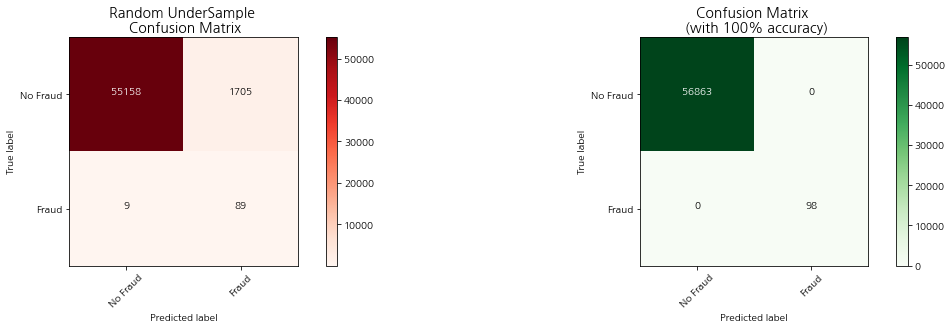

In [83]:
fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix",
                     cmap=plt.cm.Reds)
fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", 
                      cmap=plt.cm.Greens)

- Keras, OverSampling(SMOTE)

In [84]:
n_inputs = Xsm_train.shape[1]
oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation = 'relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [85]:
oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [86]:
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size = 300,
                    epochs=20, shuffle=True, verbose=2)

Epoch 1/20
971/971 - 1s - loss: 0.0770 - accuracy: 0.9715 - val_loss: 0.0788 - val_accuracy: 0.9685
Epoch 2/20
971/971 - 1s - loss: 0.0178 - accuracy: 0.9945 - val_loss: 0.0148 - val_accuracy: 0.9975
Epoch 3/20
971/971 - 1s - loss: 0.0099 - accuracy: 0.9977 - val_loss: 0.0076 - val_accuracy: 0.9993
Epoch 4/20
971/971 - 1s - loss: 0.0070 - accuracy: 0.9985 - val_loss: 0.0049 - val_accuracy: 0.9999
Epoch 5/20
971/971 - 1s - loss: 0.0054 - accuracy: 0.9989 - val_loss: 0.0065 - val_accuracy: 0.9997
Epoch 6/20
971/971 - 1s - loss: 0.0042 - accuracy: 0.9991 - val_loss: 0.0093 - val_accuracy: 0.9994
Epoch 7/20
971/971 - 1s - loss: 0.0037 - accuracy: 0.9993 - val_loss: 0.0062 - val_accuracy: 0.9997
Epoch 8/20
971/971 - 1s - loss: 0.0034 - accuracy: 0.9993 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 9/20
971/971 - 1s - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 10/20
971/971 - 1s - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.0018 - val_accuracy: 1.0000

In [90]:
oversample_fraud_predictions = oversample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

Confusion matrix, without normalization
[[56842    21]
 [   29    69]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


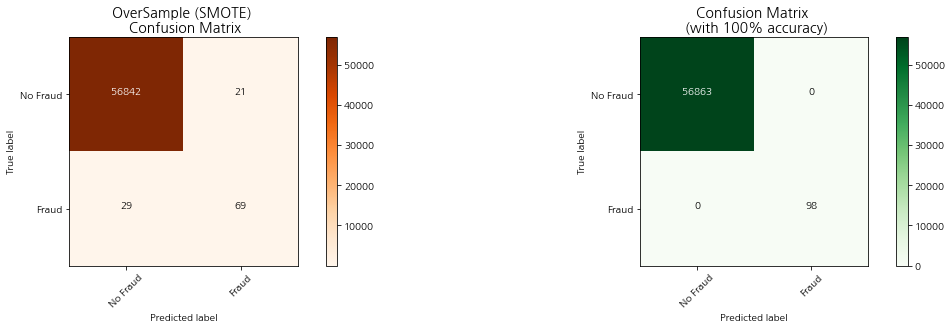

In [92]:
oversample_smote = confusion_matrix(original_ytest, oversample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

- 결론
    - 불균형 데이터 세트에 SMOTE를 구현하면 레이블의 불균형을 해결할 수 있었다.
    - 때때로 OverSampling data set를 사용한 신경망은 UnderSampling data set를 사용하는 모델보다 `덜` 정확한 Fraud를 예측한다. 
    - 그러나 특이치 제거는 OverSampling된 데이터 집합이 아니라 Random UnderSampling 데이터에서만 실행해야한다.
    - 또한 UnderSampling 데이터 를 사용한 모델에서는 많은 수의 Non-Fraud 트랜잭션에 대해 정확하게 감지 할수 없다. Non-Fraud 거래 또한, Fraud 거래로 잘못 분류할 수 있다.